# Anomaly Detection

> The map is not the territory and data is not the world observed. 
> Data is messy, inconsistent, and unreliable. The world is messier, 
> less consistent, and less reliable.<br/>–c.f. Alfred Korzybski.

When we think about anomaly detection, there are two distinct, and mostly independent, concepts that go by the name.  The topic of this chapter is perhaps the less exciting of the two.  Security and cryptography researchers, importantly, look for anomalies that can represent fraud, forgery, and system intrusion attempts.  By the intention of perpetrators, these outliers in the normal patterns of data are subtle and hard to detect, and a conflict exists between those wishing to falsify data and those wishing to detect that falsification.

The concept of interest to us in this book is more quotidian.  We wish to detect those cases where data goes bad in the ordinary course of its collection, collation, transmission, and transcription.  Perhaps an instrument gives a bad reading some or all of the time.  Perhaps some values are systematically altered in the course of reencoding to a different data format.  Perhaps the wrong units of measure were used for a subset of the data.  And so on.  By accident, these broader checks may occasionally identify changes that reflect actual malice, but more often they will simply detect errors, and *perhaps* bias (but less often, since bias still is usually towards *plausible* values).

Anomaly detection has an especially close connection to chapter 5 (*Data Quality*), and often to the topic of chapter 6 (*Value Imputation*).  The loose contrast between this chapter and the next one on data quality is that anomalies are individual data values that can be diagnosed as probably wrong, whereas data quality more broadly looks at *patterns* of the data set as a whole that can present or identify problems.  When anomalies *are* detected it sometimes makes sense to impute more likely values rather than discard those observations altogether.  In terms of the structure of this book, the lessons of this chapter will allow you to identify and mark anomalies as "missing" while chapter 6 will pick up with filling in those better imputed values (imputation is simply replacing missing data points with values that are likely, or at least plausible).

These connected chapters—4 5, and 6—form a broader unit, and roughly describe a pipeline or series of steps.  That is, given your inevitably flawed data you might first look for anomalies and mark them missing.  Next you might look for more systematic attributes of your data set, and remediate them in various ways.  Finally, you might impute (or drop) data that was either missing to start with or marked so because of properties this chapter will help you detect.  The step past the final step of this sequence is the actual modeling or analysis you perform, and is the subject of many excellent books, but not of this one.<sup><i>cleancode</i></sup>

<div id="cleancode"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>cleancode</i><br/>
My mention of these steps is a good opportunity to repeat an admonishment that has occurred elsewhere herein.  The steps of your data processing pipeline should be coded and documented carefully and reproducibly.  It is often easy and tempting to make changes to data sets in an exploratory way—as this book does—but in the process lose a good record of exactly what steps were taken.  The exploration is an integral part of data science, but reproducibility should not be lost in that process.  Good practice is to retain your original data set—in whatever data format it originally presents itself—and generate the final version via scripts (maintained in version control) rather than within notebooks or interactive shells.  Care must always be taken to allow someone else to repeatably move from the raw original data set to the version that is fed into a machine learning model or other analytic tool. Keeping an audit trail of what tool or function produced what change is hygenic practice.
</div>

---

Before we get to the sections of this chapter, let us run our standard setup code.

In [1]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R
library(tidyverse)
require("RPostgreSQL")

## Missing Data

> Gregory: Is there any other point to which you would wish to draw my attention?<br/>
> Holmes: To the curious incident of the dog in the night-time.<br/>
> Gregory: The dog did nothing in the night-time.<br/>
> Holmes: That was the curious incident.<br/>–Arthur Conan Doyle

**Concepts**:

* Sentinels versus explicit absence
* Semantics of NULL, NaN, and N/A
* Nullable columns in SQL
* Absence in hierarchies
* Pitfalls of sentinels

Some data formats explicitly support missing data while other formats use a special values, known as a sentinel value, of one sort or another to indicate missingness.  Non-tabular formats may indicate missing data simply by not including any value in a position where it might otherwise occur.  However, sentinel values are sometimes ambiguous, unfortunately.

In particular, within many data formats, and within most data frame libraries, missing numeric values are represented by the special IEEE-754 floating-point value NaN (Not-a-Number).  The problem here is that NaN, by design and intention, can arise as the result of some attempts at computation that are not obviously unreasonable.  While such an unrepresentable value is indeed *unavailable*, this is potentially semantically different from data that was simply never collected in the first place.  As a small digression, let us look at coaxing a NaN to arise in an "ordinary" computation (albeit a contrived one).

In [3]:
for n in range(7, 10):
    exp1 = 2**n
    a = (22/7) ** exp1 
    b = π ** exp1
    # Compute answer in two "equivalent" ways
    res1 = (a * a) / (b * b)
    res2 = (a / b) * (a / b)
    print(f"n={n}:\n  "
          f"method1: {res1:.3f}\n  "
          f"method2: {res2:.3f}")

n=7:
  method1: 1.109
  method2: 1.109
n=8:
  method1: 1.229
  method2: 1.229
n=9:
  method1: nan
  method2: 1.510


Parallel to the pitfall of missing floats being represented as NaNs, missing strings are almost always represented as *strings*.  Generally, one or more reserved values such as 'N/A' or the empty string are used when a string value is missing.  However, those sentinels do not clearly distinguish between "not applicable" and "not available" which are subtly different.  

As a toy example, we might have collected names of people, including "middle name."  Having a sentinel value for middle name would not distinguish between survey subjects who have no middle name and those who merely had not provided it.  Reaching just slightly for a data science purpose: perhaps we wish to find the correlation between certain middle names and demographic characteristics.  In the United States, for example, the middle name "Santiago" would be strongly associated with Hispanic family origin; a survey subject who provided no middle name might nonetheless have that middle name.  In principle, a string field could contain different sentinels for, e.g. "No middle name" and "No response" but data sets are *very rarely* careful in those distinctions.

### SQL

In SQL databases, an explicit NULL is available for all column types.  Whether a particular column is "nullable" is determined by the database administrator (or whoever had that functional role, however much or little qualified).  This allows a distinction in principle between an explicit NaN for a numeric field and a NULL for missing values.  

Unfortunately, many or most actual database tables fail to utilize these available distinctions (i.e. the specific configured and populated tables).  In practice, you are likely to see many combinations of empty strings, NaNs, actual NULLs, or other sentinels, even within SQL databases. This is not because any widely used RDBMS fails to support these different values and types, it is rather that in the history of various clients putting data into them, using various codebases, non-optimal choices were made.

To run the code in the next cells, you need to obtain access to an RDBMS.  The PostgreSQL server running on my local system, in particular, has a database called `dirty`, and that in turn contains a table called `missing`.  If you use a different RDBMS, your driver will have a different name, and your engine will use a different scheme in its connection URL.  The particular user, password, host, and port will also vary.  Database servers also often use authentication methods other than a password to grant access.  However, the Python DB-API (*database API*) is quite consistent, and you will work with the connection object and engine in identical ways when you access other RDBMS's.  For illustrative purposes, we show the PostgreSQL configuration function `connect_local()` which is contained in `setup.py`.

In [4]:
# PostgreSQL configuration
def connect_local():
    user = 'cleaning'
    pwd = 'data'
    host = 'localhost'
    port = '5432'  
    db = 'dirty'
    con = psycopg2.connect(database=db, host=host, user=user, password=pwd)
    engine = create_engine(f'postgresql://{user}:{pwd}@{host}:{port}/{db}')
    return con, engine

With the connection established, we can examine some of our data in Python.

In [5]:
con, engine = connect_local()
cur = con.cursor()
# Look at table named "missing"
cur.execute("SELECT * FROM missing")
for n, (a, b) in enumerate(cur):
    print(f"{n+1} | {str(a):>4s} | {b}")

1 |  nan | Not number
2 | 1.23 | A number  
3 | None | A null    
4 | 3.45 | Santiago  
5 | 6.78 |           
6 | 9.01 | None


As Python objects, an SQL NULL is represented as the singleton None, which is a reasonable choice.  Let us review this friendly data representation.

* Row 1 contains a NaN (not computable) and a string describing the row;
* Row 2 contains a regular float value and a string describing it;
* Row 3 contains an SQL NULL (not available) and a string;
* Row 4 contains a regular float value and a regular string;
* Row 5 contains a regular float value and an empty string ("not applicable");
* Row 6 contains a regular float value and a NULL ("not available").

In terms of actually supporting the distinction between a true NULL and a sentinel value like NaN, libraries are of mixed quality.  Pandas has made some strides with version 1.0 by introducing the special singleton `pd.NA` to be used as a "missing" indicator across data types, instead of `np.nan`, `None`, and `pd.NaT` (Not a Time).  However, as of this writing, the singleton is not utilized in any of the standard data readers, and getting the value into data requires special efforts.  I hope this will have improved by the time you read this.  R's Tidyverse does better because R itself has an `NA` special value.  Slightly confusingly, R also contains an *even more special* pseudo-value `NULL` which is used to indicate that something is undefined (as opposed to simply missing).  R's NULL can result from some expressions and function calls, but it cannot be an element in arrays or data frames.

In [6]:
%%R
# Notice NULL is simply ignored in the construction
tibble(val = c(NULL, NA, NaN, 0), 
       str = c("this", "that", NA))

# A tibble: 3 x 2
    val str  
  <dbl> <chr>
1    NA this 
2   NaN that 
3     0 NA   


What SQL calls NULL, R calls NA; NaN remains a separate value indicating "not computable."<sup><i>NaN</i></sup>  This allows R to interface correctly and unambiguously with SQL, or with the occasional other formats which also explicitly mark "missing" in a non-sentinel manner.

<div id="NaN"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>NaN</i><br/>
The IEEE-754 standard, in fact, reserves a large number of bit patterns as NaNs: 16 million of them for 32-bit floats, and vastly more for 64-bit floats.  Moreover, these many NaNs are divided into a generous number each for *signaling* versus *quiet* NaNs.  In concept, when the standard was developed, the choice of which of the millions of NaNs available (the "payload") could be used to record information about exactly what kind of operation led to the NaN occurring.  That said, no software used in data science—and nearly no software used in array and numeric computation—actually utilizes the distinction among the many NaNs.  In practical terms, NaN is equivalent to a singleton, like R's <code>NA</code>, Python's <code>None</code>, or Javascript's <code>null</code>.
</div>

This R code assumes the same PostgreSQL database is available as that used in the Python example.  As with the Python code, a different RDBMS will require a different driver name, and user, password, host, and port will vary in your configuration.

In [7]:
%%R
drv <- dbDriver("PostgreSQL")
con <- dbConnect(drv, dbname = "dirty",
                 host = "localhost", port = 5432,
                 user = "cleaning", password = "data")
sql <- "SELECT * FROM missing"
data <- tibble(dbGetQuery(con, sql))
data

# A tibble: 6 x 2
       a b           
   <dbl> <chr>       
1 NaN    "Not number"
2   1.23 "A number  "
3  NA    "A null    "
4   3.45 "Santiago  "
5   6.78 "          "
6   9.01  NA         


In contrast, Pandas 1.0 produces the less correct data frame. The `engine` object was configured and discussed above with the `connect_local()` function.

In [8]:
pd.read_sql("SELECT * FROM missing", engine)

a           b
0   NaN  Not number
1  1.23  A number  
2   NaN  A null    
3  3.45  Santiago  
4  6.78            
5  9.01        None

### Hierarchical Formats

In formats like JSON that nest data flexibly, there is an obvious way of representing missing data: by not representing it at all.  If you perform hierarchical processing, you will need to check for the presence or absence of a given dictionary key at a given level.  The JSON specification itself does not address NaN values, which means that some systems producing data may choose to use the Javascript `null` value in its place, producing the ambiguity we have discussed above.  However, many specific libraries extend the definition to recognize NaN (and sometimes `inf`, which is also a floating-point number) as a value.  To illustrate:

In [9]:
json.loads('[NaN, null, Infinity]')  # null becomes Python None

[nan, None, inf]

Let us represent the same data of the SQL table illustrated above in a (relatively) compact way.  Notice, however, that since in the Python `json` library NaN is a recognized value, we *could* explicitly represent all missing keys and match them with `null` as needed.  Obviously, we data scientists do not usually generate the data we need to consume; so the format we get is the one we need to process.

We can read this particular data into a Pandas DataFrame easily, subject to the sentinel limitation.  Since a data frame imposes a tabular format, the missing row/column positions must be filled with some value, in this case with a NaN as sentinel.  Of course, as discussed in chapter 2 (*Data Ingestion – Hierarchical Formats*), nested data may simply not be amenable to being represented in a tabular way.

In [10]:
json_data = '''
{"a": {"1": NaN, "2": 1.23, "4": 3.45, "5": 6.78, "6": 9.01},
 "b": {"1": "Not number", "2": "A number", "3": "A null",
       "4": "Santiago", "5": ""}
}'''

In [11]:
pd.read_json(json_data).sort_index()

a           b
1   NaN  Not number
2  1.23    A number
3   NaN      A null
4  3.45    Santiago
5  6.78            
6  9.01         NaN

Let us also process this JSON data in a more hierarchical and procedural way for illustration, classifying special/missing values as we encounter them.  For the example, we assume that the top level is a dictionary of dictionaries, but obviously we could walk other structures as well if needed.

In [12]:
data = json.loads(json_data)
rows = {row for dct in data.values() 
            for row in dct.keys()}

for row in sorted(rows):
    for col in data.keys():
        val = data[col].get(row)
        if val is None:
            print(f"Row {row}, Col {col}: Missing")
        elif isinstance(val, float) and math.isnan(val):
            print(f"Row {row}, Col {col}: Not a Number")
        elif not val:
            print(f"Row {row}, Col {col}: Empty value {repr(val)}")

Row 1, Col a: Not a Number
Row 3, Col a: Missing
Row 5, Col b: Empty value ''
Row 6, Col b: Missing


### Sentinels

In textual data formats, mainly delimited and fixed width files, missing data is indicated either by absence or by a sentinel.  Both delimited and fixed width formats are able to omit a certain field in a row—albeit, in fixed width, this does not distinguish among an empty string, a string of spaces, and a missing value.  Two commas next to each other in CSV should be unambiguous for "no value." Ideally, this absence should be used to indicate missingness, and potentially allow some other sentinel to indicate "Not Applicable", "Not Calculable", "No Middle Name", or other specific markers for known values that fall outside the domain of a variable.  In practice, however, the "best practice" I recommend here is often not what is used in the data sets you will actually need to work with.

Use of sentinels is not limited to text formats.  Often in SQL, for example, TEXT or CHAR columns that could, in principle, be made nullable and use NULL to indicate mising values instead use sentinels (and not always single sentinels; in practice they often acquire multiple markers over multiple generations of software changes).  Sometimes formats such as JSON that can hold text values likewise use sentinels rather than omitting keys.  Even in formats like HDF5 that enforce data typing, sometimes sentinel numeric values are used to indicate missing values rather than relying on NaN as a special marker (which has its own problems, discussed above).

In Pandas, in particular, as of version 1.0, the following sentinel values are recognized by default as meaning "missing" when reading delimited or fixed width files: '', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'. Some of these must arise in domains or from tools I am personally unfamiliar with, but many I have seen.  However, I have also encountered numerous sentinels not in that list.  You will need to consider sentinels for your specific data set, and such defaults are only some first guesses the tool provides.  Other tools will have different defaults.

Libraries for working with data sets, often as data frames, will have mechanisms to specify the particular values to treat as sentinels for missing data.  Let us look at an example that is closely based on real-world data obtained from the United States National Oceanic and Atmospheric Administration (NOAA).  This data was, in fact, provided as CSV files;  a more descriptive filename is used here, and many of the columns are omitted.  But only one data value is changed in the example.  In other words, this is a data set I actually had to work with outside of writing this book, and the issues discussed were not ones I knew about in advance of doing that.

The data set we read below concerns weather measurements at a particular weather station.  The station at Sorstokken, Norway, is chosen here more-or-less at random from thousands available. Others stations employ the same encoding, which is nowhere obviously documented.  Unfortunately, undocumented or underdocumented field contraints are the rule in published data, not the exception.  The column names are somewhat abbreviated, but not too hard to guess the meaning of: temperature (℉), maximum wind gust speed (mph), etc.

In [13]:
sorstokken = pd.read_csv('data/sorstokken-no.csv.gz')
sorstokken

STATION        DATE  TEMP  VISIB   GUST  DEWP
0    1001499999  2019-01-01  39.7    6.2   52.1  30.4
1    1001499999  2019-01-02  36.4    6.2  999.9  29.8
2    1001499999  2019-01-03  36.5    3.3  999.9  35.6
3    1001499999     UNKNOWN  45.6    2.2   22.0  44.8
..          ...         ...   ...    ...    ...   ...
295  1001499999  2019-12-17  40.5    6.2  999.9  39.2
296  1001499999  2019-12-18  38.8    6.2  999.9  38.2
297  1001499999  2019-12-19  45.5    6.1  999.9  42.7
298  1001499999  2019-12-20  51.8    6.2   35.0  41.2

[299 rows x 6 columns]

We notice a few things in the view of a selection of the table.  The DATE value UNKNOWN is included (by my construction).  Also, some GUST values are 999.9 (in the original data).  The use of several 9 digits as a sentinel is a common convention.  The number of 9s used varies, however, as well as does the position of a decimal point if any is used.  Another common convention is using a -1 as a sentinel for numeric values that semantically must be positive for legitimate values.  For example, the -1 convention might sensibly be used for wind gust speed, but it could not be for degrees Fahrenheit or Celsius which can perfectly well have the value -1 for ordinary Earth surface temperatures.  On the other hand, if we were using the same units to measure the temperatures inside an iron forge (melting point of iron is 2,800℉/1,538℃), -1 would be safely outside the possible operating range.

Looking at the minimum and maximum values of a given variable is often a clue about the sentinels used.  For numbers—and also for dates—a value that is *unreasonably large* or *unreasonably small* is generally used for a sentinel.  This can go wrong where legitimate measurements later exceed their initially anticipated range.

In [14]:
pd.DataFrame([sorstokken.min(), sorstokken.max()])

STATION        DATE  TEMP  VISIB   GUST  DEWP
0  1001499999  2019-01-01  27.2    1.2   17.1  16.5
1  1001499999     UNKNOWN  88.1  999.9  999.9  63.5

Here we see that TEMP and DEWP seem always to fall within a "reasonable" range.  DATE alerts us to a problem value this way; it might also do so, but possibly more subtly, if the sentinel had been, e.g. 1900-01-01, which is an actual date but one from before NOAA measurements were taken.  Likewise, VISIB and GUST have unreasonably high and *special* looking values.  For string values, sentinels are quite likely to occur right in the middle of valid values.  "No Middle Name" is alphabetically between "Naomi" and "Nykko."  Let us look more closely at these variables with sentinels.  Outliers and standard deviation (σ) are discussed more in a later section.

In [15]:
print("Normal max:")
for col in ['VISIB', 'GUST']:
        s = sorstokken[col]
        print(col, s[s < 999.9].max(), 
              "...standard deviation w/ & w/o sentinel:",
              f"{s.std():.1f} / {s[s < 999.9].std():.1f}")

Normal max:
VISIB 6.8 ...standard deviation w/ & w/o sentinel: 254.4 / 0.7
GUST 62.2 ...standard deviation w/ & w/o sentinel: 452.4 / 8.1


I believe VISIB is measured in miles, and seeing a thousand miles is unreasonable.  GUST wind speed is in MPH, and likewise 999.9 is not something that will occur on Earth.  However, one should worry when sentinels are within three orders of magnitude of actual values, as here.  For power law distributed values, even that rule of thumb about orders of magnitude is of little help.

In Pandas and other tools, we can instruct the tool to look for specific sentinels, and substitute specific values.  Of course, we could do so after data is read into a data structure using regular data frame filtering and manipuation techniques.  If we can do so at read time, so much the better.  Here we look for sentinels on a column-specific basis:

In [16]:
sorstokken = pd.read_csv('data/sorstokken-no.csv.gz', 
                         na_values={'DATE': 'UNKNOWN', 
                                    'VISIB': '999.9',
                                    'GUST': '999.9'},
                         parse_dates=['DATE'])
sorstokken.head()

STATION       DATE  TEMP  VISIB  GUST  DEWP
0  1001499999 2019-01-01  39.7    6.2  52.1  30.4
1  1001499999 2019-01-02  36.4    6.2   NaN  29.8
2  1001499999 2019-01-03  36.5    3.3   NaN  35.6
3  1001499999        NaT  45.6    2.2  22.0  44.8
4  1001499999 2019-01-06  42.5    1.9   NaN  42.5

The topics in this section are largely driven by data formats themselves.  Let us turn to anomalies caused more often by collection processes.

## Miscoded Data

> "When I use a word," Humpty Dumpty said, in rather a scornful 
> tone, "it means just what I choose it to mean—neither more 
> nor less."<br/>–Lewis Carroll

**Concepts**:

* Categorical and ordinal constraints
* Encoded values and metadata definitions
* Rare categories

When I discuss miscoded data in this section, I am primarily addressing categorical data, also called "factors" in R (and sometimes elsewhere).  Ordinal data might be included too inasmuch as it has known bounds.  For example, if a ranking scale is specified as ranging from 1 to 10, any values outside of that numeric range—or if genuinely ordinal, any values that are not integral—must be miscoded in some manner.

Quantitative data can obviously be miscoded as well, in some sense.  A data entry intending a value of 55 might be carelessly entered as 555.  But equally, a value intended as 55 might be mis-entered as 54, which is less likely to be caught as obviously wrong.  In any event, examination of quantitative features for errors is addressed in the later sections of this chapter.  Numbers, especially real numbers (or complex numbers, integers, fractions, etc.) do not present as immediately wrong, but only in their distribution or domain constraints.

For an ordinal value, verifying its type and range should assure the validity of the coding, in most cases (ordinals with non-contiguous integers as valid values do occur sometimes, but less common).  In the [Dermatology Data Set](https://archive.ics.uci.edu/ml/datasets/Dermatology) available from the UCI Machine Learning Repository, most fields are coded as 0, 1, 2, or 3. One field is only 0 or 1, the age and target (the skin condition) are continuous and factor variables, respectively.  In this example, nothing is miscoded; note that verifying that is *not* the same as knowing all values are *correct*.

In [17]:
from src.dermatology import *
(pd.DataFrame(
    [derm.min(), derm.max(), derm.dtypes])
     .T
     .rename(columns={0:'min', 1:'max', 2:'dtype'})
)

min                  max  \
erythema                                             0                    3   
scaling                                              0                    3   
definite borders                                     0                    3   
itching                                              0                    3   
...                                                ...                  ...   
inflammatory monoluclear inflitrate                  0                    3   
band-like infiltrate                                 0                    3   
Age                                                  0                   75   
TARGET                               cronic dermatitis  seboreic dermatitis   

                                       dtype  
erythema                               int64  
scaling                                int64  
definite borders                       int64  
itching                                int64  
...                                      ...  
inflammatory monoluclear inflitrate    int64  
band-like infiltrate                   int64  
Age                                  float64  
TARGET                                object  

[35 rows x 3 columns]

Minimum, maximum and verifying use of integer data type is sufficient to assure ordinals are not miscoded.  Categorical variables are *sometimes* encoded in an ordinal fashion, but often consist of words naming their values.  For example, the below data set is very similar to the one used in an exercise of chapter 6.  However, in this version, some errors exist that we will look at in the next several sections.  This data contains (hypothetical) height, weight, hair length, and favorite color of 25,000 suvey subjects.

In [18]:
humans = pd.read_csv('data/humans-err.csv')
# random_state for deterministic sample
humans.sample(5, random_state=1)  

Height     Weight  Hair_Length Favorite
21492  176.958650  72.604585         14.0      red
9488   169.000221  79.559843          0.0     blue
16933  171.104306  71.125528          5.5      red
12604  174.481084  79.496237          8.1     blue
8222   171.275578  77.094118         14.6    green

As one would expect semantically, `Favorite` is a categorical value, with a small number of legitimate values.  Generally the way to examine such a feature for miscoding starts with examing the unique values it takes.  Obviously, if documentation exists as to the expected values that can help us.  However, keep in mind a software developers' motto that "documentation" is a synonym for "*lies*." It may not accurately reflect the data itself.

In [19]:
humans.Favorite.unique()

array(['red', 'green', 'blue', 'Red', ' red', 'grееn', 'blüe',
       'chartreuse'], dtype=object)

At an initial look at unique values, we already see several likely problems.  For example, `' red'` with a space at the beginning is a common kind of data entry error, and we can most likely assume it was intended simply as `'red'`.  On the other hand, `'Red'` capitalized versus in lower case is not necessarily self-evident as to which is correct.  The string `'blüe'` looks like another misspelling of the English word.  Something strange is happening with the `'green'` still; we will return to that.

To get a sense of the intention of the data, we can check whether some variations are rare with others common.  This is often a strong hint.

In [20]:
humans.Favorite.value_counts()

red           9576
blue          7961
green         7458
grееn            1
 red             1
blüe             1
chartreuse       1
Red              1
Name: Favorite, dtype: int64

These counts tell us a lot.  The color `'chartreuse'` is a perfectly good color name, albeit a less commonly used word. It *could* be a legitimate value, but most likely its rarity indicates some sort of improper entry, given that only three colors (modulo some spelling issues we are working on) seem to be otherwise available.  Most likely, we will want to mark this value as missing for later processing.  But *only* most likely; there may be domain knowledge that indicates that despite its rarity, it is a value we wish to consider.  If documentation exists describing it, that lends weight to the option of simply keeping it.

The rare occurrence of `' red'` with a leading space and `'Red'` capitalized give us strong support for the assumption that they are simply miscoded version of 'red'.  However, if we were roughly evenly split on capitalized and lowercase versions, or even if neither was *rare*, the correct action is less clear.  Nonetheless, in many cases, canonicalization or normalization to one particular case (case folding) would be good practice, and data frame tools make this easy to vectorize on large data sets.  However, sometimes capitalization represent intended differences, for example in otherwise identical last names that have distinct capitalization among different families.  Likewise, in many scientific fields, short names or formulae can be case-sensitive and should not be case-folded.  Having a sense of the content domain remains important.

We are left with the curious case of the two greens.  They look identical; likewise, for example a trailing space in the above categorical values would not be visible on screen.  Manually looking closer at those values is needed here.

In [21]:
for color in sorted(humans.Favorite.unique()):
    print(f"{color:>10s}", [ord(c) for c in color])

       red [32, 114, 101, 100]
       Red [82, 101, 100]
      blue [98, 108, 117, 101]
      blüe [98, 108, 252, 101]
chartreuse [99, 104, 97, 114, 116, 114, 101, 117, 115, 101]
     green [103, 114, 101, 101, 110]
     grееn [103, 114, 1077, 1077, 110]
       red [114, 101, 100]


What we find here from the Unicode code points is that one of our greens in fact has two Cyrillic 'ye' characters rather than Roman 'e's.  This substitution of near-identical glyphs is often—as in this instance of a sneaky book author—a result of malice or deception.  However, in the large world of human languages, it genuinely can occur that a particular string of characters innocently resembles some other string it is not.  Other than perhaps making it more difficult to type some strings at the particular keyboard with which you are familiar, this visual similarity is not per se a data integrity issue.  However, here, with the one mixed-language version also being rare, clearly it is something to correct to the regular English word in Roman letters.

Once we have made decisions about the remediations desired—in a manner sensitive to domain knowledge—we can translate troublesome values.  For example:

In [22]:
humans.loc[humans.Favorite.isin(['Red', ' red']), 'Favorite'] = 'red'
humans.loc[humans.Favorite == 'chartreuse', 'Favorite'] = None
humans.loc[humans.Favorite == 'blüe', 'Favorite'] = 'blue'
humans.loc[humans.Favorite == 'grееn', 'Favorite'] = 'green'
humans.Favorite.value_counts()

red      9578
blue     7962
green    7459
Name: Favorite, dtype: int64

Let us turn to areas where domain knowledge can inform anomaly detection.

## Fixed Bounds

> Cricket is an art. Like all arts it has a technical foundation. To enjoy it 
> does not require technical knowledge, but analysis that is not technically
> based is mere impressionism”<br/>–C.L.R. James, _Beyond A Boundary_ 

**Concepts**:

* Domain versus measurement limits
* Imputation and clipping
* Improbability versus impossibility
* Exploring hypotheses for data errors

Based on our domain knowledge of the problem and data set at hand, we may know of fixed bounds for particular variables.  For example, we might know that the tallest human who has lived was Robert Pershing Wadlow at 271㎝ ; and that the shortest adult was Chandra Bahadur Dangi at 55㎝ .  Values outside this range are probably unreasonable to allow in our data set.  In fact, we may perhaps wish to assume much stricter bounds; as an example, let us choose between 92㎝ and 213㎝ (which will include the *vast* majority of all adult humans).  Let us check whether our humans data set conforms with these bounds.

In [23]:
((humans.Height < 92) | (humans.Height > 213)).any()

False

For height, then, our domain specific fixed bounds are not exceeded in the data set.  What about the variable `Hair_Length`?  From the actual physical meaning of the measurement, hair cannot be negative length.  However, let us stipulate as well that the measuring tape used for our observations was 120㎝ (i.e. hypothetical domain knowledge), and that, therefore, a length more than that cannot be completely legitimate (such a length is rare, but not impossible among humans).  First, let us look at the hair lengths that exceed the measuring instrument.

In [24]:
humans.query('Hair_Length > 120')

Height     Weight  Hair_Length Favorite
1984   165.634695  62.979993        127.0      red
8929   175.186061  73.899992        120.6     blue
14673  174.948037  77.644434        130.1     blue
14735  176.385525  68.735397        121.7    green
16672  173.172298  71.814699        121.4      red
17093  169.771111  77.958278        133.2     blue

There are just a few samples with a hair length longer than a possible measurement.  However, all of these numbers are only modestly longer than the measuring instrument or scale.  Without more information on the collection procedure, it is not possible to be confident of the source of the error.  Perhaps some subjects made their own estimates of their very long hair length rather than use the instrument.  Perhaps one data collection site actually had a longer measuring tape that was not documented in our metadata or data description.  Or perhaps there is a transcription error, such as adding a decimal point; e.g. maybe the 124.1㎝ hair was 24.1㎝ in reality. Or perhaps the unit was confused, and millimeters were actually measured rather than centimeters (as is standard in hair clippers and other barbering equipment).

In any case, this problem affects only 6 of the 25,000 observations.  Dropping those rows would not lose a large amount of data, so that is a possibility.  Imputing values would perhaps be reasonable (for example, stipulating these 6 subjects had average hair length).  Value imputation is the subject of chapter 6, and options are discussed there in more detail; at this stage, the first pass might be marking those values as missing.

However, for these out-of-range values that cluster relatively close to legitimate values, clipping the values to the documented maximum might also be a reasonable approach.  The operation "clip" is also sometimes called "clamp," "crop," or "trim" depending on the library you are working with.  The general idea is simply that a value outside of a certain bound is treated as if it is that bound itself.  We can version our data as we modify it.

In [25]:
humans2 = humans.copy()  # Retain prior versions of data set
humans2['Hair_Length'] = humans2.Hair_Length.clip(upper=120)
humans2[humans2.Hair_Length > 119]

Height     Weight  Hair_Length Favorite
1984   165.634695  62.979993        120.0      red
4146   173.930107  72.701456        119.6      red
8929   175.186061  73.899992        120.0     blue
9259   179.215974  82.538890        119.4    green
14673  174.948037  77.644434        120.0     blue
14735  176.385525  68.735397        120.0    green
16672  173.172298  71.814699        120.0      red
17093  169.771111  77.958278        120.0     blue

A slightly lower threshold for a filter shows that 119.6 was left unchanged, but the values over 120.0 were all set to 120 exactly.

The too big values were not difficult to massage.  Let us look at the physical lower bound of zero next. A value of exactly zero is perfectly reasonable.  Many people shave their head or are otherwise bald.  This is invented data, pulled from a distribution that feels vaguely reasonable to this author, so do not put too much weight in the exact distributions of lengths.  Just note that zero length is a relatively common occurrence in actual humans.

In [26]:
humans2[humans2.Hair_Length == 0]

Height     Weight  Hair_Length Favorite
6      177.297182  81.153493          0.0     blue
217    171.893967  68.553526          0.0     blue
240    161.862237  76.914599          0.0     blue
354    172.972247  73.175032          0.0      red
...           ...        ...          ...      ...
24834  170.991301  67.652660          0.0    green
24892  177.002643  77.286141          0.0    green
24919  169.012286  74.593809          0.0     blue
24967  169.061308  65.985481          0.0    green

[517 rows x 4 columns]

However, what about the impossible negative lengths?  We can easily create a filter to look at those also.

In [27]:
neg_hair = humans2[humans2.Hair_Length < 0]
neg_hair

Height     Weight  Hair_Length Favorite
493    167.703398  72.567763         -1.0     blue
528    167.355393  60.276190        -20.7    green
562    172.416114  60.867457        -68.1    green
569    177.644146  74.027147         -5.9    green
...           ...        ...          ...      ...
24055  172.831608  74.096660        -13.3      red
24063  172.687488  69.466838        -14.2    green
24386  176.668430  62.984811         -1.0    green
24944  172.300925  72.067862        -24.4      red

[118 rows x 4 columns]

There are a moderate number of these obviously miscoded rows.  As elsewhere, simply dropping the problem rows is often a reasonable approach.  However, a quick glance at the tabular data, as well as some slight forensics, suggest that quite likely a negative sign snuck into many reasonable values.  It is at least *plausible* that these quantities are right, but simply with inverted sign.  Let us look at some statstics of the problem values.  Just for fun, we will look at very similar summaries using both R and Pandas.

In [28]:
%%R -i neg_hair
summary(neg_hair$Hair_Length)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -95.70  -38.08  -20.65  -24.35   -5.60   -0.70 


In [29]:
neg_hair.Hair_Length.describe()

count    118.000000
mean     -24.348305
std       22.484691
min      -95.700000
25%      -38.075000
50%      -20.650000
75%       -5.600000
max       -0.700000
Name: Hair_Length, dtype: float64

The general statistics do not contradict this sign-inversion hypothesis.  However, before we draw a conclusion, let us continue to look at these bad values more closely for this exercise.  There might be additional patterns.

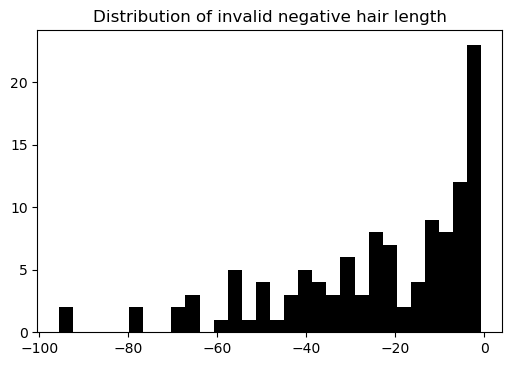

In [30]:
plt.hist(neg_hair.Hair_Length, bins=30)
plt.title("Distribution of invalid negative hair length")
plt.savefig("img/(Ch04)Distribution of invalid negative hair length.png")

This distribution of negative values roughly matches the distribution of positive ones.  There are a larger number of people with short hair of varying short lengths, and a tail of fewer people at longer lengths.  However, at a glance, the region close to zero seems to be a bit *too much* of a peak.  For the one hundred or so rows of data in the example, you could eyeball them all manually, but for larger data sets, or larger bounds-violation sets, honing in on nuances programmatically is more general.

In [31]:
neg_hair.Hair_Length.value_counts()

-1.0     19
-41.6     2
-6.8      2
-30.1     2
         ..
-3.3      1
-51.4     1
-25.1     1
-4.8      1
Name: Hair_Length, Length: 93, dtype: int64

Indeed there is a pattern here.  There are 19 values of *exactly* -1, and only 1 or two occurrences of each other invalid negative value.  It seems very likely that something different is happening between the -1 error and the other negative value errors.  Perhaps -1 was used as a sentinel, for example.  Of course, it is also possible that -1 could result from the stipulated sign-inversion error; we cannot entirely separate those two possibilities.

The working hypothesis I would probably use to handle this problem in the data set (if not simply drop everything questionable outright) would be to mark the -1 values as *missing* but invert the sign of other negative values.

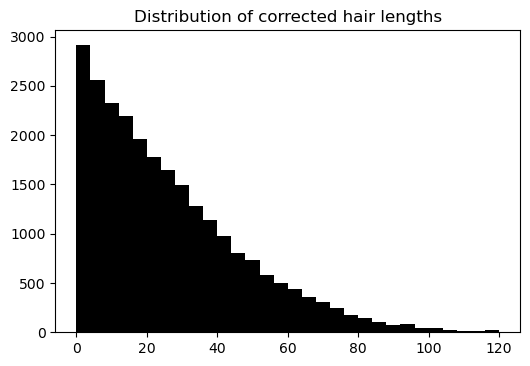

In [32]:
humans3 = humans2.copy()     # Versioned changes to data

# The "sentinel" negative value means missing
humans3.loc[humans3.Hair_Length == -1, 'Hair_Length'] = None

# All other values simply become non-negative
humans3['Hair_Length'] = humans3.Hair_Length.abs()

plt.hist(humans3.Hair_Length, bins=30)
plt.title("Distribution of corrected hair lengths")
plt.savefig("img/(Ch04)Distribution of corrected hair lengths.png")

We have performed a typical cleaning of bounded values.  Let us turn to values without sharp bounds, but with general distribution statistics.

## Outliers 

> If Congress had meant to so limit the Act, it surely would have used words 
> to that effect.<br/>–Tennessee Valley Auth. v. Hill, 437 U.S. 153 (1978)

**Concepts**:

* Z-score and unexpected values
* Interquartile range
* Standard deviation and frequency of occurrence

In continuous data, values that fall within normative ranges might still be strongly uncharacteristic within those bounded expectations.  In the simplest case, this occurs when a value is very different from other values of the same variable.  The standard way to characterize the expectedness of a value is a measure called z-score.  This value is simply the distance of each point from the mean of the variable, divided by the standard deviation of the variable. 

$$Z = \frac{x - \mu}{\sigma}$$

Where $\mu$ is sample mean, and $\sigma$ is standard deviation.

This measure is most precise for data that follows a normal distribution, but generally it is useful for any data that is unimodal (having one peak), somewhat symmetric, and scale dependent.  In more ordinary language, we just want to look for the histogram of a data variable having one peak, and tapering off at roughly the same rate on both sides.  Completely normal distribution is unusual in real-world data.

A slightly different way of identifying outliers is often used as well.  Box and whisker plots (usually simply called boxplots) will often include outliers as separate visual elements.  While it is possible to use z-score in such a visualization, more often these plots utilize interquartile range (IQR) and a fixed multiplier to define outliers.  The different techniques will produce similar, but not identical, answers.

### Z-Score

We can see that height and weight in our data set follow a generally normal-like distribution by visualizing them.  We have seen just above that hair length, after correction, is strictly single tailed.  However, the one-sided drop-off from a mode at 0 is close enough to one tail of a normal distribution, that z-score is still reasonable to consider.

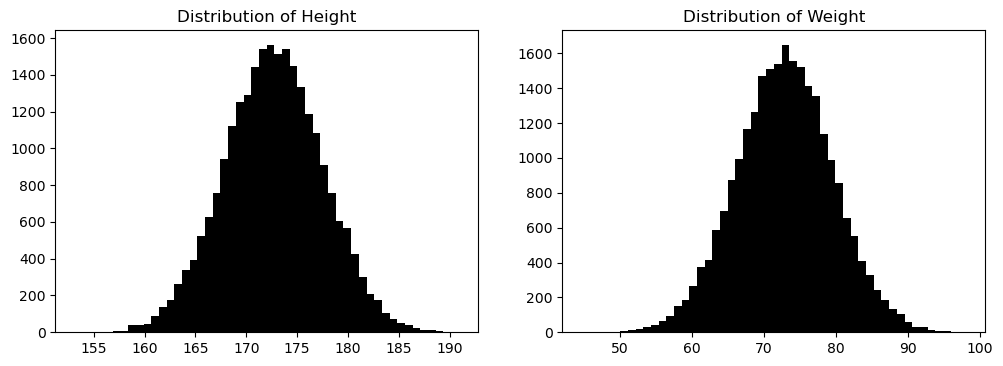

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(humans3.Height, bins=50)
ax2.hist(humans3.Weight, bins=50)
ax1.set_title("Distribution of Height")
ax2.set_title("Distribution of Weight")
fig.savefig("img/(Ch04)Distribution of Height and Weight.png")

If we wish to be more precise in quantifying normality of variables, we can use statistical tests such and Anderson-Darling, Shapiro–Wilk, or Skewness-Kurtosis All.  Each of these techniques tries to reject the hypothesis that a distribution is normal.  For different p-values (probabilities), different test statistics determine a threshold for this rejection (although for large samples, even small deviations from normality will reject the hypothesis, but not matter from the point of view of z-score being useful).  In Anderson-Darling, if the test statistic is not much more than 1.0 the curve is definitely *normal enough* to measure outliers with z-score.  The inverse does not hold, however; many non-normal curves are still reasonable to use z-score with.  Essentially, we just need to avoid this measure for power law or exponential distributions, and for curves that are strongly multi-modal. Let us perform Anderson-Darling tests on our height, weight, and hair length variables.Let us perform Anderson-Darling tests on our height, weight, and hair length variables.

In [34]:
from scipy.stats import anderson

for var in ('Height', 'Weight', 'Hair_Length'):
    data = humans3[var][humans3[var].notnull()]
    stat = anderson(data, 'norm').statistic
    print(f"Anderson-Darling statistic for {var:<12s}: {stat:6.2f}")

Anderson-Darling statistic for Height      :   0.24
Anderson-Darling statistic for Weight      :   0.54
Anderson-Darling statistic for Hair_Length : 578.19


Having recognized that hair length is not normal, but that it shows a one-sided decay along a linear scale nonetheless, we can add z-scores for all of our quantitative variables to the working data frame.  As before, as good practice of keeping versions of our modifications, we copy the data to a new data frame before the next transformations.  We ignore the delta degrees of freedom parameter in our calculation of standard deviation because it is trivial with 25 thousand samples (if we had only 10 or 20 samples, it could matter).  The degrees of freedom concerns the anticipated variance within a total population based on a sample; but these only vary significantly when samples are tens of observations, not tens of thousands.The degrees of freedom concerns the anticipated variance within a total population based on a sample; but these only vary significantly when samples are tens of observations, not tens of thousands.

In [35]:
humans4 = humans3.copy()

for var in ('Height', 'Weight', 'Hair_Length'):
    zscore = (humans4[var] - humans4[var].mean()) / humans4[var].std()
    humans4[f"zscore_{var}"] = zscore
    
humans4.sample(5, random_state=1)

Height     Weight  Hair_Length Favorite  zscore_Height  \
21492  176.958650  72.604585         14.0      red       0.880831   
9488   169.000221  79.559843          0.0     blue      -0.766210   
16933  171.104306  71.125528          5.5      red      -0.330758   
12604  174.481084  79.496237          8.1     blue       0.368085   
8222   171.275578  77.094118         14.6    green      -0.295312   

       zscore_Weight  zscore_Hair_Length  
21492      -0.042032           -0.568786  
9488        0.997585           -1.225152  
16933      -0.263109           -0.967294  
12604       0.988078           -0.845397  
8222        0.629028           -0.540656

The choice of a z-score threshold is very domain and problem dependent.  A rule of thumb is often to use a z-score of absolute value more than 3 as a cut-off to define outliers.  But what is *expected* very much depends on the size of a data set.  In statistics, we sometimes recall the "68–95–99.7 Rule" which lists the percentage of observations that fall within one, two, or three standard deviations in a normal distribution.  At any distance from the mean, *some* observations would be expected if they are numerous enough, but the number diminishes rapidly with more standard deviations distance.

Let us look at that common z-score threshold of 3.  Remember that we are working with 25,000 samples here, so generally we expect to find roughly 75 of them outside of 3 standard deviations, under the "68–95–99.7 rule" discussed below.  Let us look at the table for height, but just check the number of rows outside this bound for the other variables.

In [36]:
humans4[humans4.zscore_Height.abs() > 3]

Height     Weight  Hair_Length Favorite  zscore_Height  \
138    187.708718  86.829633         19.3    green       3.105616   
174    187.537446  79.893761         37.5     blue       3.070170   
412    157.522316  62.564977          6.8     blue      -3.141625   
1162   188.592435  86.155948         53.1      red       3.288506   
...           ...        ...          ...      ...            ...   
22945  157.293031  44.744929         18.4      red      -3.189077   
23039  187.845548  88.554510          6.9     blue       3.133934   
24244  158.153049  59.725932         13.8    green      -3.011091   
24801  189.310696  85.406727          2.3    green       3.437154   

       zscore_Weight  zscore_Hair_Length  
138         2.084216           -0.320304  
174         1.047496            0.532971  
412        -1.542673           -0.906345  
1162        1.983518            1.264351  
...              ...                 ...  
22945      -4.206272           -0.362499  
23039       2.342037           -0.901657  
24244      -1.967031           -0.578162  
24801       1.871531           -1.117320  

[51 rows x 7 columns]

In [37]:
print("Outlier weight:", (humans4.zscore_Weight.abs() > 3).sum())
print("Outlier hair length:", (humans4.zscore_Hair_Length.abs() > 3).sum())

Outlier weight: 67
Outlier hair length: 285


We have already noted that hair length is single tailed, so we might expect approximately twice as many outliers.  The actual number is somewhat more than twice that many, but that is not itself an extreme divergence of values.  Height and weight actually have modestly lower kurtosis than we would expect from the normal distribution (the tails thin out slightly faster).  In any case, a z-score of 3 is probably too small to be useful for our sample size.  4 sigma is probably more relevant for our purpose of distinguishing merely unusual from probably-wrong observations, and maybe 4.5 for the one-tailed hair length.

A table of the frequency of once-a-day observations falling outside of a given standard deviation (σ) provides a helpful intuition.  A shorthand trick to remember the effect of sigma is the so-called *68–95–99.7 rule*; that is, the percentage of things falling within one, two, and three standard deviations.

| Range | Proportion of observations | Frequency for daily event 
|-------|----------------------------|:---------------------------------
| ± 1σ  | 1 in 3                     | Twice a week
| ± 2σ  | 1 in 22                    | Every three weeks 
| ± 3σ  | 1 in 370                   | Yearly
| ± 4σ  | 1 in  15,787               | 43 years (twice in a lifetime)
| ± 5σ  | 1 in  1,744,278            | 5000 years (once in recorded history)
| ± 6σ  | 1 in  506,797,346          | 1.4 million years (twice in history of humankind)
| ± 7σ  | 1 in  390,682,215,445      | 1 billion years (four times in history of Earth) 

Let us see the outliers given the broader z-score bounds.

In [38]:
cond = (
    (humans4.zscore_Height.abs() > 4) |
    (humans4.zscore_Weight.abs() > 4) |
    (humans4.zscore_Hair_Length.abs() > 4.5))
humans4[cond] 

Height     Weight  Hair_Length Favorite  zscore_Height  \
13971  153.107034  63.155154          4.4    green      -4.055392   
14106  157.244415  45.062151         70.7      red      -3.199138   
22945  157.293031  44.744929         18.4      red      -3.189077   

       zscore_Weight  zscore_Hair_Length  
13971      -1.454458           -1.018865  
14106      -4.158856            2.089496  
22945      -4.206272           -0.362499

Using modest domain knowledge of human physical characteristics, even though they are outside the "norm," persons of  153㎝ or 45kg are small, but not outside of bounds we would expect.  The small number of 4 sigma outliers are both short and light according to the data, which we would expect to be correlated to a relatively high degree, lending plausibility to the measurements.  Moreover, the height bounds we discussed in the above section on fixed bounds were considerably wider than this 4 sigma (or even 5 sigma) detects.  Therefore, while we *could* discard or mark missing values in these outliers rows, the analysis does not seem to motivate doing so.

### Interquartile Range

Using interquartile range (IQR) rather than z-score makes less of an assumption of normality of a distribution.  However, this technique will also fails to produce meaningful answers for power law or exponential data distributions.  If you can identify a distribution as one that ranges over many orders of magnitude like those, looking at the quartiles of either an Nth root or a logarithm of the raw data might still produce reasonable results.  The same transformation, in fact, can be equally relevant if you use z-score analysis.

The idea of IQR is simply to look at the quartile cut-offs in a variable, and measure the numeric distance between the first and third quartile, i.e. between the 25% and 75% percentiles.  Exactly half the data is in that range, but we often also expect that most data will be within some distance beyond those cut-offs, defined as a multiplier of the range between cut-offs.  Most commonly, a multiplier of 1.5 is chosen; this is merely a convention that is often useful but lacks any deeper meaning.

I include in this text a brief function to visualize boxplots that show the IQR defined outliers.  Normally, this functionality is only included in the source code repository for the book, but here I think it is worthwhile for readers to see the configuration that goes into these few lines in **Matplotlib** (other visualization libraries have similar capabilities; often higher-level abstractions with more visual pizzazz, in fact).

In [39]:
# Function defined but not run in this cell
def show_boxplots(df, cols, whis=1.5):
    # Create as many horizontal plots as we have columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(10, 2*len(cols)))
    # For each one, plot the non-null data inside it
    for n, col in enumerate(cols):
        data = df[col][df[col].notnull()]
        axes[n].set_title(f'{col} Distribution')
        # Extend whiskers to specified IQR multiplier
        axes[n].boxplot(data, whis=whis, vert=False, sym='x')
        axes[n].set_yticks([])
    # Fix spacing of subplots at the end
    fig.tight_layout()
    plt.savefig(f"img/boxplot-{'_'.join(cols)}.png")

While the default multiplier (the "whisker" width) is 1.5, we have already seen that the human data is large enough that values have to be relatively extreme to appear as genuinely *unlikely* to be genuine.  We choose, therefore, a whisker width of 2.5 instead.  

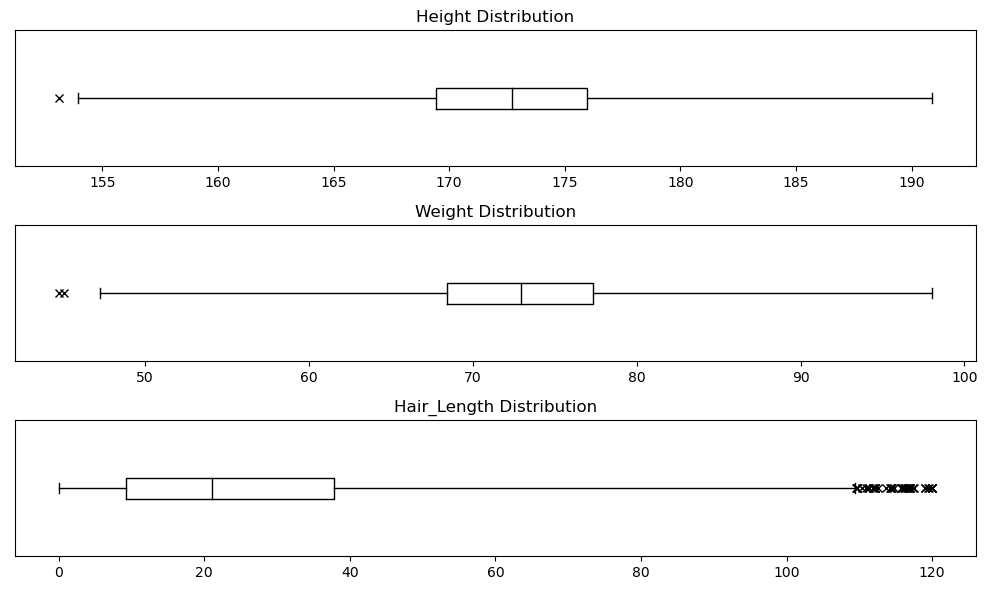

In [40]:
show_boxplots(humans4, ["Height", "Weight", "Hair_Length"], 2.5)

The central boxes represent the IQR, from 25% to 75% percentile.  The whiskers extend to multiplier times IQR above/below the box.  An x marks outliers past the whiskers.The central boxes represent the IQR, from 25% to 75% percentile.  The whiskers extend to multiplier times IQR above/below the box.  An x marks outliers past the whiskers.

Only one outlier appears at this threshold for height, at the short end.  Likewise, only two appear for weight, both at the light end.  This was the same pattern we found with z-score.  Rather more "outlier" long hair length occurs, but we already had used a larger z-score to filter that more restrictively.  We could similarly use a larger *whisker* width to filter more hair lengths out, if we wished.

While the visualization is handy, we want to find the actual data rows that are marked with x's in the plots.  Let us code that.  We find the quartiles, compute the IQR, then display the inlier ranges.

In [41]:
quartiles = (
    humans4[['Height', 'Weight']]
    .quantile(q=[0.25, 0.50, 0.75, 1.0]))
quartiles

Height     Weight
0.25  169.428884  68.428823
0.50  172.709078  72.930616
0.75  175.953541  77.367039
1.00  190.888112  98.032504

In [42]:
IQR = quartiles.loc[0.75] - quartiles.loc[0.25]
IQR

Height    6.524657
Weight    8.938216
dtype: float64

In [43]:
for col, length in IQR.iteritems():
    high = quartiles.loc[0.75, col] + 2.5*IQR[col]
    low = quartiles.loc[0.25, col] - 2.5*IQR[col]
    print(f"Inliers for {col}: [{low:.3f}, {high:.3f}]")

Inliers for Height: [153.117, 192.265]
Inliers for Weight: [46.083, 99.713]


Actually filtering using the inlier range in this case gives us the same answer as the z-score approach.  Of necessity, the very shortest person is the shortest regardless of which outlier detection technique we use.  But selecting a domain motivated IQR multiplier may identify more or fewer outliers than using a domain motivated z-score, depending on actual data distributions.

In [44]:
cond = (
    (humans4.Height > 192.265) |
    (humans4.Height < 153.117) |
    (humans4.Weight > 99.713)  |
    (humans4.Weight < 46.083))
humans4[cond] 

Height     Weight  Hair_Length Favorite  zscore_Height  \
13971  153.107034  63.155154          4.4    green      -4.055392   
14106  157.244415  45.062151         70.7      red      -3.199138   
22945  157.293031  44.744929         18.4      red      -3.189077   

       zscore_Weight  zscore_Hair_Length  
13971      -1.454458           -1.018865  
14106      -4.158856            2.089496  
22945      -4.206272           -0.362499

Univariate outliers can be important to detect, but sometimes it is a combination of features that becomes anomalous.

## Multivariate Outliers 

> If you are not part of the solution, you are part of the precipitate.<br/>–Anonymous

**Concepts**:

* Variance in deterministic synthetic features
* Expectations of relative rarity

Sometimes univariate features can fall within relatively moderate z-score boundaries, and yet combinations of those features are unlikely or unreasonable.  Perhaps an actual machine learning model might predict that combinations of features are likely to be wrong.  In this section we only look at simpler combinations of features to identify problematic samples.

In chapter 7 (*Feature Engineering*) we discuss polynomial features.  That technique multiplies together the values of two or more variables pertaining to the same observation, and treats that as a new feature.  For example, perhaps neither height nor weight in our working example are outside a reasonable bound, and yet the multiplicative product of them is.  While this is definitely possible, we generally expect these features to be positively correlated to start with, so multiplication would probably only produce something new *slightly* outside the bounds already detected by univariate outlier detection.


However, let us consider a derived feature that is well-motivated by the specific domain.  Body mass index (BMI) is a measure often used to measure healthy weights for people, and is defined as:

$$BMI = \frac{kg}{m^2}$$

That is, weight and height are in an inverse relationship in this derived quantity rather than multiplicatively combined.  Perhaps this multivariate derived features shows some problem outliers.  Let us construct another data frame version that discards previous calculated columns, but adds BMI and its z-score.

In [45]:
humans5 = humans4[['Height', 'Weight']].copy()
# Convert weight from cm to m
humans5['BMI'] = humans5.Weight / (humans5.Height/100)**2
humans5["zscore_BMI"] = (
    (humans5.BMI - humans5.BMI.mean()) / 
     humans5.BMI.std()
)
humans5

Height     Weight        BMI  zscore_BMI
0      167.089607  64.806216  23.212279   -0.620410
1      181.648633  78.281527  23.724388   -0.359761
2      176.272800  87.767722  28.246473    1.941852
3      173.270164  81.635672  27.191452    1.404877
...           ...        ...        ...         ...
24996  163.952580  68.936137  25.645456    0.618008
24997  164.334317  67.830516  25.117048    0.349063
24998  171.524117  75.861686  25.785295    0.689182
24999  174.949129  71.620899  23.400018   -0.524856

[25000 rows x 4 columns]

Looking for outliers in the derived feature, we see strong signals.  As was discussed, at a z-score of 4 and a data set of 25,000 records, we expect to see slightly more than one record appearing as an outlier by natural random distribution.  Indeed, the two z-scores we see below that are only slightly more than 4 in absolute value occurred in the data set before it was engineered to highlight the lesson of this section.

In [46]:
humans5[humans5.zscore_BMI.abs() > 4]

Height     Weight        BMI  zscore_BMI
21388  165.912597  90.579409  32.905672    4.313253
23456  187.110000  52.920000  15.115616   -4.741383
23457  158.330000  92.780000  37.010755    6.402625
24610  169.082822  47.250297  16.527439   -4.022805

As well as one example of a moderate outlier for high BMI and one for low BMI, we also have two more extreme values on each side.  In this case, these were constructed for the section, but similar multivariate outliers will occur in the wild.  The -4.74 z-score is not an extreme we would expect in 25,000 samples, but is perhaps not completely implausible.  However, the +6.4 z-score is astonomically unlikely to occur without a data error (or a construction by a book author).  Since BMI is a derived feature that combines height and weight—and moreover since each of those is within reasonable bounds on its own—the correct approach is almost surely simply to discard these problem rows.  Nothing in the data themselves guide us towards knowing whether weight or height is the problem value, and no remediation is sensible.

Fortunately for this particular data set, only 2 (or *maybe* 4) samples display the problem under discussion.  We have plentiful data here, and no real harm is done by discarding those rows.  Obviously, the particular decisions made about z-score thresholds and disposition of particular data rows that are illustrated in this section and the last several are only examples.  You will need to decide within your problem and domain what are most relevant levels and tests, and what remediations to perform.

## Exercises

The two exercises in this chapter ask you to look for anomalies first in quantitative data, then in categorical data.

### A Famous Experiment

The Michelson–Morley experiment was an attempt in the late 19th century to detect the existence of the *luminiferous aether*, a widely assumed medium that would carry light waves.  This was the most famous "failed experiment" in the history of physics in that it did not detect what it was looking for—something we now know not to exist at all.  The general idea was to measure the speed of light under different orientations of the equipment relative to the direction of movement of the earth, since relative movement of the ether medium would add or subtract from the speed of the wave.  Yes, it does not work that way under the theory of relativity, but it was a reasonable guess 150 years ago.

Apart from the physics questions, the data set derived by the Michelson-Morley experiment is widely available, including as a sample built into R.  The same data is available at:

> https://www.gnosis.cx/cleaning/morley.dat

Figuring out the format, which is not complex, is a good first step of this exercise (and typical of real data science work).

The specific numbers in this data are measurements of the speed of light in km/s with a zero point of 299,000.  So, for example, the mean measurement in experiment 1 was 299,909 km/s.  Let us look at the data in the R bundle.

In [47]:
%%R -o morley
data(morley)
morley %>%
    group_by(`Expt`) %>%
    summarize(Mean = mean(Speed), Count = max(Run))

`summarise()` ungrouping output (override with `.groups` argument)
# A tibble: 5 x 3
   Expt  Mean Count
  <int> <dbl> <int>
1     1  909     20
2     2  856     20
3     3  845     20
4     4  820.    20
5     5  832.    20


In the summary, we just look at the number of runs of each experimental setup, and the mean across that setup.  The raw data has 20 measurements within each setup.

Using whatever programming language and tools you prefer, identify the outliers first within each setup (defined by an `Expt` number) and then within the data collection as a whole.  The hope in the original experiment was that each setup would show a significant difference in central tendency, and indeed their means are somewhat different.  This book and chapter does not explore confidence levels and null hypotheses in any detail, but create a visualization that aids you in gaining visual insight into how much apparent difference exists between the several setups.

If you discard the outliers within each setup, are the differences between setups increased or decreased? Answer with either a visualization or by looking at statistics on the reduced groups.

### Misspelled Words

For this exercise we return to the 25,000 human measurements we have used to illustrate a number of concepts.  However, in this variation of the data set, each row has a person's first name (pulled from the US Social Security Agency list of common first names over the last century; apologies that the names lean Anglocentric because of the past history of US population and immigration trends).

The data set for this exercise can be found at:

> https://www.gnosis.cx/cleaning/humans-names.csv

Unfortunately, our hypothetical data collectors for this data set are simply terrible typists, and they make typos when entering names with alarming frequency.  There are some number of intended names in this data set, but quite a few simple miscodings of those names as well.  The problem is: how do we tell a real name from a typo?

There are a number of ways to measure the similarity of strings, and that provide a clue as to likely typos.  One general class of approach is in terms of *edit distance* between strings. The R package **stringdist**, for example provides Damerau-Levenshtein, Hamming, Levenshtein, and optimal sting alignment, as measures of edit distance.  Less edit-specific fuzzy matching techniques utilize a "bag of n-grams" approach, and include q-gram, cosine distance, and Jaccard distance. Some heuristic metrics like Jaro and Jaro-Winkler are also included in `stringdist` along with the other measures mentioned.  Soundex, soundex variants, and metaphone look for similarity of the sounds of words as pronounced, but are therefore specific to language and even regional dialect.

In a reversal of the more common pattern of Python versus R libraries, Python is the one that scatters string similarity measures over numerous libraries, each including just a few measures.  However, **python-Levenshtein** is a very nice package including most of these measures.  If you want cosine similarity, you may have to use `sklearn.metrics.pairwise` or another module.  For phonetic comparisons, **fonetika** and **soundex** both support multiple languages (but different languages for each; English is in common for almost all packages).

On my personal system, I have a command-line utility called `similarity` that I use to measure how close strings are to each other.  This particular few line script measures Levenshtein distance, but also normalizes it to the length of the longer string.  A short name will have a small numeric measure of distance, even betweeen dissimilar strings, while long strings that are close overall can have a larger measure before normalization (depending on what measure is chosen, but for most of them).  A few examples show this.

In [48]:
%%bash 
similarity David Davin

Levenshtein distance: 1
Similarity ratio: 0.8


In [49]:
%%bash
similarity David Maven

Levenshtein distance: 3
Similarity ratio: 0.4


In [50]:
%%bash
similarity "the quick brown fox jumped" \
           "thee quikc brown fax jumbed"

Levenshtein distance: 5
Similarity ratio: 0.814814814815


For this exercise, your goal is to identify every *genuine* name, and correct all the misspelled ones to the correct canonical spelling.  Keep in mind that sometimes multiple legitimate names are actually close to each other in terms of similarity measures.  However, it is probably reasonable to assume that *rare* spellings are typos, at least if they are also relatively similar to common spellings.  You may use whatever programming language, library, and metric you feel is the most useful for the task.

Reading in the data, we see it is similar to the human measures we have seen before.

In [51]:
names = pd.read_csv('data/humans-names.csv')
names.head()

Name      Height     Weight
0    James  167.089607  64.806216
1    David  181.648633  78.281527
2  Barbara  176.272800  87.767722
3     John  173.270164  81.635672
4  Michael  172.181037  82.760794

It is easy to see that some "names" occur very frequently and others only rarely.  Look at the middling values as well in working on this exercise.

In [52]:
names.Name.value_counts()

Elizabeth    1581
Barbara      1568
Jessica      1547
Jennifer     1534
             ... 
Josep           1
iWlliam         1
Joseeph         1
eJennifer       1
Name: Name, Length: 249, dtype: int64

## Denouement

> When you have eliminated the impossible, whatever remains, 
> however improbable, must be the truth.<br/>
> –Arthur Conan Doyle

**Topics**: Missing Data; Sentinels; Miscoded Data; Fixed Bounds; Outliers

The anomalies that we have discussed in this chapter fall into a few relatively distinct categories.  For the first kind, there are the special values that explicitly mark missing data, although those markers are sometimes subject to pitfalls.  However, an explicit indication of missingness is probably the most straightforward kind of anomaly.  A second kind of anomaly are categorical values that a miscoded; some finite number of values are proper (although not always clearly documented), and anything that isn't one of those few values is an anomaly.

The third kind of anomaly is in continuous—or at least ranged—data values that fall outside of the bounds of our expectations.  These are also called *outliers*, although exactly how much a value has to lie outside typical values to be a problem is very domain and problem dependent.  Expectations may take the form of a priori that arise from domain knowledge of the measurement.  They may also arise from the distribution of data within a variable overall, and the deviation of one particular value from others measured as that variable.  At times, our expectations about bounds can even be multivariate, and some numeric combination of multiple variables produces a value outside of expectation bounds.

For all of these kinds of anomalies, there are essentially two actions we might take.  We may decide to discard an observation or sample altogether if it has one of these problems.  Or alternately, we may simply more explicitly mark one feature within an observation as explicitly missing based on its value not being reliable.  When we modify values to the "missing" special value, keeping track of our changes and data versions is extremely important practice.  What we choose to do with those values marked as explicitly missing is a downstream decision that is discussed at more length in later chapters.

In the next chapter we move from looking for problems with particular data points and into looking for problems with the overal “shape” of a data set.